# 量子神经网络在自然语言处理中的应用

## 概述

在自然语言处理过程中，词嵌入（Word embedding）是其中的重要步骤，它是一个将高维度空间的词向量嵌入到一个维数更低的连续向量空间的过程。当给予神经网络的语料信息不断增加时，网络的训练过程将越来越困难。利用量子力学的态叠加和纠缠等特性，我们可以利用量子神经网络来处理这些经典语料信息，加入其训练过程，并提高收敛精度。下面，我们将简单地搭建一个量子经典混合神经网络来完成一个词嵌入任务。

导入本教程所依赖模块

In [1]:
# pylint: disable=W0104
import sys
import mindspore as ms

path = '../'
sys.path.append(path)                                        # 添加自主开发的量子模拟器代码所在路径
ms.set_context(mode=ms.GRAPH_MODE, device_target="Ascend")   # 使用静态图

In [2]:
import numpy as np
import time
import mindspore as ms
import mindspore.ops as ops
import mindspore.dataset as ds
from mindspore import nn

from gates import RX, RY, X, H
from circuit import Circuit, UN
from expect import Expectation

本教程实现的是一个[CBOW模型](https://blog.csdn.net/u010665216/article/details/78724856)，即利用某个词所处的环境来预测该词。例如对于“I love natural language processing”这句话，我们可以将其切分为5个词，\["I", "love", "natural", "language", "processing”\]，在所选窗口为2时，我们要处理的问题是利用\["I", "love", "language", "processing"\]来预测出目标词汇"natural"。这里我们以窗口为2为例，搭建如下的量子神经网络，来完成词嵌入任务。

![quantum word embedding](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.0.0-alpha/docs/mindquantum/docs/source_zh_cn/images/qcbow.png)

这里，编码线路会将"I"、"love"、"language"和"processing"的编码信息编码到量子线路中，待训练的量子线路由四个Ansatz线路构成，最后我们在量子线路末端对量子比特做$\text{Z}$基矢上的测量，具体所需测量的比特的个数由所需嵌入空间的维数确定。

## 数据预处理

我们对所需要处理的语句进行处理，生成关于该句子的词典，并根据窗口大小来生成样本点。

In [3]:
def GenerateWordDictAndSample(corpus, window=2):
    all_words = corpus.split()
    word_set = list(set(all_words))
    word_set.sort()
    word_dict = {w: i for i, w in enumerate(word_set)}
    sampling = []
    for index, _ in enumerate(all_words[window:-window]):
        around = []
        for i in range(index, index + 2*window + 1):
            if i != index + window:
                around.append(all_words[i])
        sampling.append([around, all_words[index + window]])
    return word_dict, sampling

In [4]:
word_dict, sample = GenerateWordDictAndSample("I love natural language processing")
print(word_dict)
print('word dict size: ', len(word_dict))
print('samples: ', sample)
print('number of samples: ', len(sample))

{'I': 0, 'language': 1, 'love': 2, 'natural': 3, 'processing': 4}
word dict size:  5
samples:  [[['I', 'love', 'language', 'processing'], 'natural']]
number of samples:  1


根据如上信息，我们得到该句子的词典大小为5，能够产生一个样本点。

## 编码线路

为了简单起见，我们使用的编码线路由$\text{RX}$旋转门构成，结构如下。

![encoder circuit](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.0.0-alpha/docs/mindquantum/docs/source_zh_cn/images/encoder.png)

我们对每个量子门都作用一个$\text{RX}$旋转门。

In [5]:
def GenerateEncoderCircuit(n_qubits, prefix=''):
    if prefix and prefix[-1] != '_':
        prefix += '_'
    circ = Circuit()
    for i in range(n_qubits):
        circ += RX(prefix + str(i)).on(i)
    return circ.as_encoder()

In [6]:
print(GenerateEncoderCircuit(3, prefix='e'))

Circuit<
  (gates): SequentialCell<
    (0): RX(e_0)<0>
    (1): RX(e_1)<1>
    (2): RX(e_2)<2>
    >
  >


我们通常用$\left|0\right>$和$\left|1\right>$来标记二能级量子比特的两个状态，由态叠加原理，量子比特还可以处于这两个状态的叠加态：

$$\left|\psi\right>=\alpha\left|0\right>+\beta\left|1\right>$$

对于$n$比特的量子态，其将处于$2^n$维的希尔伯特空间中。对于上面由5个词构成的词典，我们只需要$\lceil \log_2 5 \rceil=3$个量子比特即可完成编码，这也体现出量子计算的优越性。

例如对于上面词典中的"love"，其对应的标签为2，2的二进制表示为`010`，我们只需将编码线路中的`e_0`、`e_1`和`e_2`分别设为$0$、$\pi$和$0$即可。下面来验证一下。

In [7]:
n_qubits = 3 # number of qubits of this quantum circuit
label = 2 # label need to encode
label_bin = bin(label)[-1: 1: -1].ljust(n_qubits, '0') # binary form of label
label_array = np.array([int(i)*np.pi for i in label_bin]).astype(np.float32) # parameter value of encoder
encoder = GenerateEncoderCircuit(n_qubits, prefix='e') # encoder circuit
encoder_params_names = encoder.params_name # parameter names of encoder

print("Label is: ", label)
print("Binary label is: ", label_bin)
print("Parameters of encoder is: \n", np.round(label_array, 5))
print("Encoder circuit is: \n", encoder)
print("Encoder parameter names are: \n", encoder_params_names)

# quantum state evolution operator
state = encoder.get_qs(pr=dict(zip(encoder_params_names, label_array)))
amp = np.round(np.abs(state)**2, 3)

print("Amplitude of quantum state is: \n", amp)
print("Label in quantum state is: ", np.argmax(amp))

Label is:  2
Binary label is:  010
Parameters of encoder is: 
 [0.      3.14159 0.     ]
Encoder circuit is: 
 Circuit<
  (gates): SequentialCell<
    (0): RX(e_0)<0>
    (1): RX(e_1)<1>
    (2): RX(e_2)<2>
    >
  >
Encoder parameter names are: 
 ['e_0', 'e_1', 'e_2']
Amplitude of quantum state is: 
 [0. 0. 1. 0. 0. 0. 0. 0.]
Label in quantum state is:  2


通过上面的验证，我们发现，对于标签为2的数据，最后得到量子态的振幅最大的位置也是2，因此得到的量子态正是对输入标签的编码。我们将对数据编码生成参数数值的过程总结成如下函数。

In [8]:
def GenerateTrainData(sample, word_dict):
    n_qubits = np.int32(np.ceil(np.log2(1 + max(word_dict.values()))))
    data_x = []
    data_y = []
    for around, center in sample:
        data_x.append([])
        for word in around:
            label = word_dict[word]
            label_bin = bin(label)[-1: 1: -1].ljust(n_qubits, '0')
            label_array = [int(i)*np.pi for i in label_bin]
            data_x[-1].extend(label_array)
        data_y.append(word_dict[center])
    return np.array(data_x).astype(np.float32), np.array(data_y).astype(np.int32)

In [9]:
GenerateTrainData(sample, word_dict)

(array([[0.       , 0.       , 0.       , 0.       , 3.1415927, 0.       ,
         3.1415927, 0.       , 0.       , 0.       , 0.       , 3.1415927]],
       dtype=float32),
 array([3]))

根据上面的结果，我们将4个输入的词编码的信息合并为一个更长向量，便于后续神经网络调用。

## Ansatz线路

Ansatz线路的选择多种多样，我们选择如下的量子线路作为Ansatz线路，它的一个单元由一层$\text{RY}$门和一层$\text{CNOT}$门构成，对此单元重复$p$次构成整个Ansatz线路。

![ansatz circuit](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.0.0-alpha/docs/mindquantum/docs/source_zh_cn/images/ansatz.png)

定义如下函数生成Ansatz线路。

In [10]:
def GenerateAnsatzCircuit(n_qubits, layers, prefix=''):
    if prefix and prefix[-1] != '_':
        prefix += '_'
    circ = Circuit()
    for l in range(layers):
        for i in range(n_qubits):
            circ += RY(prefix + str(l) + '_' + str(i)).on(i)
        for i in range(l % 2, n_qubits, 2):
            if i < n_qubits and i + 1 < n_qubits:
                # 注：sporequantum不兼容 mindquantum 的 X.on(i+1, i)，用 X(i+1, i)代替
                circ += X(i + 1, i)
    return circ.as_ansatz()

In [11]:
print(GenerateAnsatzCircuit(5, 2, 'a'))

Circuit<
  (gates): SequentialCell<
    (0): RY(a_0_0)<0>
    (1): RY(a_0_1)<1>
    (2): RY(a_0_2)<2>
    (3): RY(a_0_3)<3>
    (4): RY(a_0_4)<4>
    (5): X<1, 0>
    (6): X<3, 2>
    (7): RY(a_1_0)<0>
    (8): RY(a_1_1)<1>
    (9): RY(a_1_2)<2>
    (10): RY(a_1_3)<3>
    (11): RY(a_1_4)<4>
    (12): X<2, 1>
    (13): X<4, 3>
    >
  >


## 测量

我们把对不同比特位上的测量结果作为降维后的数据。具体过程与比特编码类似，例如当我们想将词向量降维为五维向量时，对于第三维的数据可以如下产生：

- 3对应的二进制为`00011`。
- 测量量子线路末态对$Z_0Z_1$哈密顿量的期望值。

下面函数将给出产生各个维度上数据所需的哈密顿量（hams），其中`n_qubits`表示线路的比特数，`dims`表示词嵌入的维度：

In [12]:
def GenerateEmbeddingHamiltonian(dims, n_qubits):
    hams = {}
    for i in range(dims):
        s = ''
        for j, k in enumerate(bin(i + 1)[-1:1:-1]):
            if k == '1':
                s = s + 'Z' + str(j) + ' '
        hams[s.strip()] = 1.0
    return hams

In [13]:
GenerateEmbeddingHamiltonian(5, 5)

{'Z0': 1.0, 'Z1': 1.0, 'Z0 Z1': 1.0, 'Z2': 1.0, 'Z0 Z2': 1.0}

## 量子版词向量嵌入层

量子版词向量嵌入层结合前面的编码量子线路和待训练量子线路，以及测量哈密顿量，将`num_embedding`个词嵌入为`embedding_dim`维的词向量。这里我们还在量子线路的最开始加上了Hadamard门，将初态制备为均匀叠加态，用以提高量子神经网络的表达能力。

下面，我们定义量子嵌入层，它将返回一个量子线路模拟算子。

In [14]:
def QEmbedding(num_embedding, embedding_dim, window, layers):
    n_qubits = int(np.ceil(np.log2(num_embedding)))
    circ = Circuit()
    circ = UN(H, n_qubits)
    encoder_param_name = []
    ansatz_param_name = []
    for w in range(2 * window):
        encoder = GenerateEncoderCircuit(n_qubits, 'Encoder_' + str(w))
        ansatz = GenerateAnsatzCircuit(n_qubits, layers, 'Ansatz_' + str(w))
        encoder.no_grad()
        circ += encoder
        circ += ansatz
        encoder_param_name.extend(encoder.params_name)
        ansatz_param_name.extend(ansatz.params_name)
    return circ

整个训练模型跟经典网络类似，由一个嵌入层和两个全连通层构成，然而此处的嵌入层是由量子神经网络构成。下面定义量子神经网络CBOW。

In [15]:
class CBOW(nn.Cell):
    def __init__(self, num_embedding, embedding_dim, window_size, layers, hidden_dim, hams):
        super(CBOW, self).__init__()
        self.circuit = QEmbedding(num_embedding, embedding_dim, window_size, layers)
        self.expe_fn = Expectation(hams)
        self.dense1 = nn.Dense(embedding_dim, hidden_dim)
        self.dense2 = nn.Dense(hidden_dim, num_embedding)
        self.relu = ops.ReLU()

    def set_encoder_value(self, pr):
        self.circuit.set_encoder_value(pr)

    def construct(self):
        embed = self.expe_fn(self.circuit())
        out = self.dense1(embed)
        out = self.relu(out)
        out = self.dense2(out)
        return out

其中的 `set_encoder_value` 函数用于给编码器赋值，在训练中输入特征是调用该函数进行编码。

接下来，利用量子版本的`CBOW`来对一个长句进行词嵌入。

In [16]:
ms.set_context(mode=ms.GRAPH_MODE)  # 使用静态图

corpus = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells."""

ms.set_seed(42)
n_qubits = 3
window_size = 2
embedding_dim = 10
hidden_dim = 128
word_dict, sample = GenerateWordDictAndSample(corpus, window=window_size)
num_embedding = len(word_dict)
train_x, train_y = GenerateTrainData(sample, word_dict)

hams = GenerateEmbeddingHamiltonian(embedding_dim, n_qubits)
net = CBOW(num_embedding, embedding_dim, window_size, layers=3, hidden_dim=hidden_dim, hams=hams)
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
optimizer = nn.Adam(net.trainable_params(), 0.005)

def forward_fn(label):
    out = net()
    loss = loss_fn(out, label)
    return loss

grad_fn = ms.value_and_grad(forward_fn, None, optimizer.parameters)

## 训练

如果使用静态图，首次迭代时间需要数十秒，但后续训练明显加快。

In [17]:
losses = []
n_epochs = 30
for e in range(n_epochs):
    loss = ms.Tensor(0.0)
    for x, y in zip(train_x, train_y):
        label = ms.Tensor(y, ms.int32).reshape((1))
        net.set_encoder_value(x)
        los, grads = grad_fn(label)
        optimizer(grads)
        loss += los
    print(f'[epoch {e:02d}], loss: {loss.numpy() / len(train_x):.4f}')
    losses.append(loss.numpy() / len(train_x))

[epoch 00], loss: 3.9209
[epoch 01], loss: 3.8079
[epoch 02], loss: 3.3968
[epoch 03], loss: 2.9274
[epoch 04], loss: 2.4462
[epoch 05], loss: 2.0294
[epoch 06], loss: 1.6607
[epoch 07], loss: 1.3459
[epoch 08], loss: 1.0954
[epoch 09], loss: 0.8979
[epoch 10], loss: 0.7355
[epoch 11], loss: 0.6009
[epoch 12], loss: 0.5037
[epoch 13], loss: 0.4160
[epoch 14], loss: 0.3502
[epoch 15], loss: 0.2940
[epoch 16], loss: 0.2477
[epoch 17], loss: 0.2125
[epoch 18], loss: 0.1791
[epoch 19], loss: 0.1544
[epoch 20], loss: 0.1331
[epoch 21], loss: 0.1147
[epoch 22], loss: 0.0985
[epoch 23], loss: 0.0841
[epoch 24], loss: 0.0721
[epoch 25], loss: 0.0606
[epoch 26], loss: 0.0518
[epoch 27], loss: 0.0438
[epoch 28], loss: 0.0371
[epoch 29], loss: 0.0328


打印收敛过程中的损失函数值：

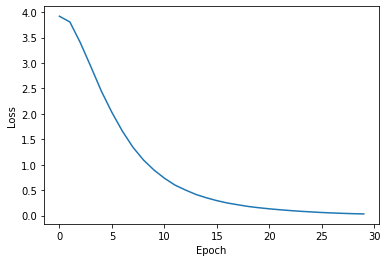

In [18]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

通过如下方法打印量子嵌入层的量子线路中的参数：

In [19]:
pr = net.circuit.parameters

## 参考文献

[1] Tomas Mikolov, Kai Chen, Greg Corrado, Jeffrey Dean. [Efficient Estimation of Word Representations in
Vector Space](https://arxiv.org/pdf/1301.3781.pdf)

[2] MindQuantum文档. [量子神经网络在自然语言处理中的应用](https://mindspore.cn/mindquantum/docs/zh-CN/r0.8/index.html)